To do:
- include 2014
- think about MMLI>1

# Seasonal cycle of MMLI

In [37]:
import sys
sys.path.insert(0, "/users/jwindmil/2019_WMI/util")

# Initial imports
import Landau_Potential_Diffusion as Landau
import curvature as curve

import xarray as xr
import numpy as np
import numpy.fft as fft
import matplotlib.pyplot as plt
import datetime
from skimage import measure
from scipy import ndimage, stats
import scipy.integrate as sin
from scipy.optimize import curve_fit
from scipy.ndimage.filters import gaussian_filter1d
import random
import pandas as pd

import pickle

In [2]:
def get_all_values(dic_values):
    values = []
    for i_k, key in enumerate(dic_values.keys()):
        values.extend(dic_values[key])
    return values

### Choose stripe like domain in the Atlantic ocean

In [3]:
latmin = -23
latmax = 23
lonmin = 360-34
lonmax = 360-18

In [25]:
PW = xr.open_mfdataset(path+'????/??PW.nc',combine='by_coords')
PWAtl = PW['tcwv'].sel({'longitude':slice(lonmin,lonmax),'latitude':slice(latmax,latmin)})
lonAtl = PW.longitude.sel({'longitude':slice(lonmin,lonmax)})
latAtl = PW.latitude.sel({'latitude':slice(latmax,latmin)})

In [23]:
LSM = xr.open_mfdataset(path+'ERA_LANDSEAMASK.nc')
LSMAtl = LSM['lsm'].sel({'longitude':slice(lonmin,lonmax),'latitude':slice(latmax,latmin)})

/users/jwindmil/venv-3.6/lib/python3.6/site-packages/xarray/backends/api.py:783: FutureWarning: In xarray version 0.13 `auto_combine` will be deprecated.
  coords=coords)
/users/jwindmil/venv-3.6/lib/python3.6/site-packages/xarray/backends/api.py:783: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset` to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in in future, please use the
new `combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  coords=coords)


In [9]:
# Calculate Area of domain assuming a rectangle (since we assumed constant dx for the contour)
dx = 110/4 #km
A_domain = PWAtl.shape[1]*PWAtl.shape[2]*(dx**2) #km**2
L_band = 2.0*PWAtl.shape[2]*dx

In [15]:
year = 2009
YEAR = np.append(np.arange(2000,2014), np.arange(2015,2018)) #2014 is missing!

In [14]:
date1 = str(2000)+'-01-01T00:00:00'
date2 = str(2013)+'-12-31T23:00:00'

test1 = PWAtl.time.sel({'time':slice(date1,date2)})

date1 = str(2015)+'-01-01T00:00:00'
date2 = str(2017)+'-12-31T23:00:00'

test2 = PWAtl.time.sel({'time':slice(date1,date2)})

time_wo14 = xr.concat([test1, test2], dim='time')

### Load contour length and area

In [6]:
path = '/project/s916/ERA5_Tom/'
path_PKL = '/users/jwindmil/2019_WMI/dev/jwindmiller/PKL_DATA/'

In [216]:
path_PKL+'CONTOURL_PW_%i_%i_%i_%i_%i_'%(latmin, latmax, lonmin, lonmax, thresh)+str(year)+'.pkl'

'/users/jwindmil/2019_WMI/dev/jwindmiller/PKL_DATA/CONTOURL_PW_-23_23_326_342_48_2009.pkl'

In [10]:
thresh = 48

# Calculate MMLI from CON_data assuming band or circle shape

MMLI_PW_data = {}
CONT_PW_data = {}
AREA_PW = {}

for i,year in enumerate(YEAR):
    print('i=',i,' & year=',year,' ',end='\r')
    hf = open(path_PKL+'CONTOURL_PW_%i_%i_%i_%i_%i_'%(latmin, latmax, lonmin, lonmax, thresh)+str(year)+'.pkl','rb')
    tmp = pickle.load(hf)
    AREA_PW[str(year)] = tmp["Tot_Area_km2"]
    MMLI_PW_data[str(year)] = L_band/tmp['Tot_Contour_km'][str(year)]
    CONT_PW_data[str(year)] = tmp['Tot_Contour_km'][str(year)]
    

/apps/dom/UES/jenkins/7.0.UP01/gpu/easybuild/software/jupyterlab/1.1.1-CrayGNU-19.10/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  


### Time evolution of MMLI

(0.2, 1.0)

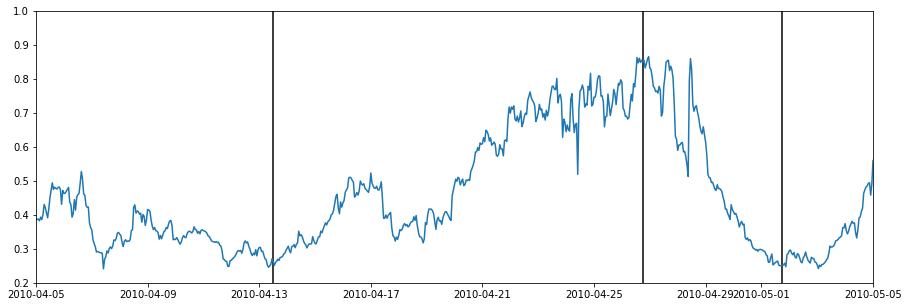

In [158]:
plt.figure(figsize=(15,5))
data_smoothed = data_t #gaussian_filter1d(data_t, sigma=4)
plt.plot(time_wo14, data_smoothed)
plt.xlim(np.datetime64('2010-04-05'), np.datetime64('2010-05-05'))

ymin, ymax = 0.2, 1.0

times_A = [np.datetime64('2010-04-13T12:00'), np.datetime64('2010-04-26T18:00'), np.datetime64('2010-05-01T18:00')]
plt.vlines(times_A, ymin, ymax)
plt.ylim(ymin, ymax)

/apps/dom/UES/jenkins/7.0.UP01/gpu/easybuild/software/jupyterlab/1.1.1-CrayGNU-19.10/lib/python3.6/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/apps/dom/UES/jenkins/7.0.UP01/gpu/easybuild/software/jupyterlab/1.1.1-CrayGNU-19.10/lib/python3.6/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


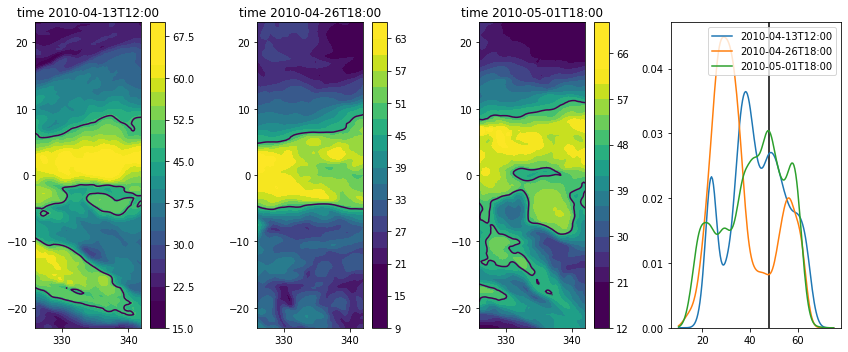

In [160]:
plt.figure(figsize=(12,5))

num_sp = len(times_A)+1
i_sp = 0

for i, time in enumerate(times_A):
    
    i_sp += 1
    
    plt.subplot(1,num_sp,i_sp)
    
    tmp = np.squeeze(PWAtl.sel({'time':time}).values) #.where(LSM['lsm']==0)
    
    plt.contour(lonAtl, latAtl, tmp, [48.00])#, vmin = 2.7e9, vmax=2.85e9)
    plt.contourf(lonAtl, latAtl, tmp, 20, vmin = 20, vmax=62)
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.title('time %s'%time)
    plt.colorbar()
    
    plt.subplot(1,num_sp,num_sp)
    
    x = np.linspace(10,75,161)
    density = stats.gaussian_kde(np.ndarray.flatten(tmp))
    plt.plot(x, density(x), label = '%s'%time)
    plt.legend()
    
ymin, ymax = plt.ylim()
plt.vlines([48], 0.0, ymax)
plt.ylim(0.0, ymax)
    
plt.tight_layout()

### Calculate seasonal cycle of MMLI

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53])

/apps/dom/UES/jenkins/7.0.UP01/gpu/easybuild/software/jupyterlab/1.1.1-CrayGNU-19.10/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in subtract
  after removing the cwd from sys.path.


(1, 12)

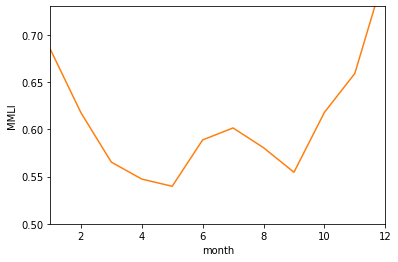

In [212]:
data_month = pd.DatetimeIndex(time_wo14.values).month

data_t = np.array(get_all_values(MMLI_PW_data))
data_t[np.isnan(data_t-data_t)] = np.nan

months = np.unique(data_month)
months_td = [np.timedelta64(months[i],'W') for i in range(len(months))]

data_w = np.arange(len(months)).astype(float)

for i, month in enumerate(months):
    data_w[i] = np.nanmean(data_t[np.where(data_month==month)])

plt.plot(months_td, data_w, 'C1')
plt.ylim(ymin=0.5, ymax=0.73)
#plt.vlines([12.0*16/52.0, 12.0*37/52.0], 0.46, 0.7)

plt.xlabel('month')
plt.ylabel('MMLI')

plt.xlim(1,12)


/apps/dom/UES/jenkins/7.0.UP01/gpu/easybuild/software/jupyterlab/1.1.1-CrayGNU-19.10/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in subtract
  


(1, 53)

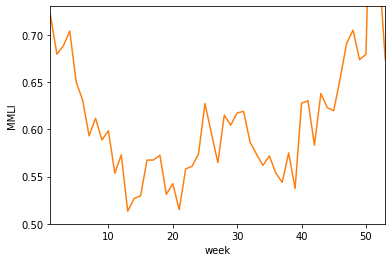

In [207]:
data_week = pd.DatetimeIndex(time_wo14.values).week

data_t = np.array(get_all_values(MMLI_PW_data))
data_t[np.isnan(data_t-data_t)] = np.nan

weeks = np.unique(data_week)
weeks_td = [np.timedelta64(weeks[i],'W') for i in range(len(weeks))]

data_w = np.arange(len(weeks)).astype(float)

for i, week in enumerate(weeks):
    data_w[i] = np.nanmean(data_t[np.where(data_week==week)])

plt.plot(weeks_td, data_w, 'C1')
plt.ylim(ymin=0.5, ymax=0.73)
#plt.vlines([12.0*16/52.0, 12.0*37/52.0], 0.46, 0.7)

plt.xlabel('week')
plt.ylabel('MMLI')

plt.xlim(1,53)


/apps/dom/UES/jenkins/7.0.UP01/gpu/easybuild/software/jupyterlab/1.1.1-CrayGNU-19.10/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in subtract
  after removing the cwd from sys.path.


(10, 350)

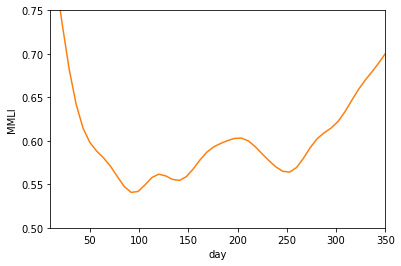

In [215]:
data_day = pd.DatetimeIndex(time_wo14.values).dayofyear

data_t = np.array(get_all_values(MMLI_PW_data))
data_t[np.isnan(data_t-data_t)] = np.nan

days = np.unique(data_day)[::7]

data_w = np.ones(len(days)).astype(float)

for i, day in enumerate(days):
    data_w[i] = np.nanmean(data_t[np.where(data_day==day)])

plt.plot(days, gaussian_filter1d(data_w, sigma=2), 'C1')
plt.ylim(ymin=0.5, ymax=0.75)
#plt.vlines([12.0*16/52.0, 12.0*37/52.0], 0.46, 0.7)

plt.xlabel('day')
plt.ylabel('MMLI')

plt.xlim(10, 350)

### Show example plots

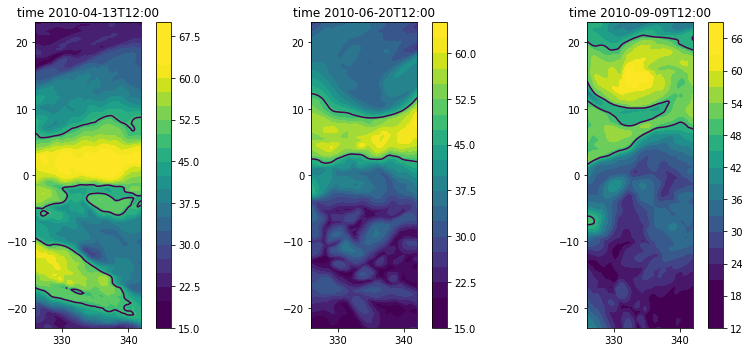

In [156]:
plt.figure(figsize=(12,5))

times2_A = [np.datetime64('2010-04-13T12:00'), np.datetime64('2010-06-20T12:00'), np.datetime64('2010-09-09T12:00')]

num_sp = len(times_A)

for i, time in enumerate(times2_A):
    
    plt.subplot(1,num_sp,i+1)
    
    tmp = np.squeeze(PWAtl.sel({'time':time}).values) #.where(LSM['lsm']==0)
    
    plt.contour(lonAtl, latAtl, tmp, [48.00])#, vmin = 2.7e9, vmax=2.85e9)
    plt.contourf(lonAtl, latAtl, tmp, 20, vmin = 20, vmax=62)
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.title('time %s'%time)
    plt.colorbar()

plt.tight_layout()